# Projet IA - HumanForYou

### Salim ZEMRI

### Contexte

HumanForYou est un entreprise indienne qui emploie 4000 personnes.  
Chaque année, 15% de l'effectif subit un turn-over, ce taux n'est pas bon pour l'entreprise car le rythme de travail est impacté.

### Objectif

On cherchera à mettre au point un ou des modèles de prédiction du départ d'un employé en fonction des autres informations et déterminer les facteurs ayant le plus d'influence sur ce taux.  

La donnée représentant le départ d'un employé ne peut prendre que deux valeurs : `Oui & Non`

### Description du modèle

Type d'apprentissage : `Supervisé`    
Type de tâche supervisée : `Classification`

### Description des données

Nous avons 5 bases de données au format _csv_ fourni par le service RH de l'entreprise sur les employés de 2015.

- general_data : Données sur les employés
- manager_survey_data : Evaluation de chaque employé par son manager
- employee_survey_data : Enquête faite par les employés sur la qualité de travail
- in_time : Horaire d'entrée
- out_time : Horaire de sortie

Ils sont stockées dans un dossier nommée _dataset_

### Chargement des données en mémoire

Nous allons utiliser [`pandas`](https://pandas.pydata.org/) pour charger les données en mémoire dans des [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#pandas.DataFrame)

In [1]:
import pandas as pd

general_data = pd.read_csv("dataset/general_data.csv")
employee_survey_data = pd.read_csv("dataset/employee_survey_data.csv")
manager_survey_data = pd.read_csv("dataset/manager_survey_data.csv")

in_time = pd.read_csv("dataset/in_time.csv")
out_time = pd.read_csv("dataset/out_time.csv")

Les bases de données ont tous un attribut en commun : `EmployeeID`

In [2]:
general_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [3]:
employee_survey_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB


In [4]:
manager_survey_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB


### Création du dataset

Notre programme de [`Machine Learning`](https://fr.wikipedia.org/wiki/Apprentissage_automatique) a besoin de données pour fonctionner.  
Dans notre projet, elles sont éparpillées et certaines ne sont pas exploitables dans leur état actuel, il faut donc créer un [`dataset`](https://fr.wikipedia.org/wiki/Jeu_de_donn%C3%A9es) en rassemblant et en modifiant ces données. La première étape sera de créer de nouveaux attributs susceptibles d'être pertinents pour notre modèle de prédiction.

#### Création de nouveaux attributs 

Note moyenne donnée par un manager pour chaque employé : `AverageManagerRating` dans une copie de `manager_survey_data`

In [5]:
manager_survey_data_copy = manager_survey_data.copy()
manager_survey_data_copy["AverageManagerRating"] = (manager_survey_data_copy["JobInvolvement"] + 
                                                    manager_survey_data_copy["PerformanceRating"]) / 2

`in_time` et `out_time` sont structuré sous forme de calendrier, on ne peut pas isoler une colonne comme pour les 3 autres bases. Nous allons donc utiliser les heures d'entrée et de sortie afin de calculer un temps moyen d'heure présent sur le lieu de travail pour chaque employé.

Temps de présence moyen par jour pour chaque employé : `MeanWorkingTime` dans un nouveau DataFrame `mean_working_time`

In [6]:
from datetime import time

in_time_copy, out_time_copy = in_time.copy(), out_time.copy()
in_time_copy, out_time_copy = in_time_copy.fillna(0), out_time_copy.fillna(0)

for k in range(1,len(in_time_copy.columns)):
    in_time_copy[in_time_copy.columns[k]] = pd.to_datetime(in_time_copy[in_time_copy.columns[k]],
                                                           format = '%Y-%m-%d %H:%M:%S')
for k in range(1,len(out_time_copy.columns)):
    out_time_copy[out_time_copy.columns[k]] = pd.to_datetime(out_time_copy[out_time_copy.columns[k]],
                                                             format = '%Y-%m-%d %H:%M:%S')

mean_working_time = pd.DataFrame(data = {'EmployeeID': [], 'MeanWorkingTime': []})
deltaTime = out_time_copy - in_time_copy

for row in range(len(deltaTime)):
    tempRow = {'EmployeeID':0, 'MeanWorkingTime':0}
    mean = 0
    
    for col in range(1,len(deltaTime.columns)):
        tempRow['EmployeeID'] = int(in_time[in_time.columns[0]][row])
        
        if deltaTime[deltaTime.columns[col]][row] != 0:
            if mean != 0:
                mean = (mean + deltaTime[deltaTime.columns[col]][row]) / 2
            else:
                mean = deltaTime[deltaTime.columns[col]][row]
                
    tempRow['MeanWorkingTime'] = mean.total_seconds() / 3600
    mean_working_time = mean_working_time.append(tempRow, ignore_index = True)

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_working_time = mean_working_time.append(tempRow, ignore_index = True)
C:\Users\szemri\AppData\Local\Temp\ipykernel_13908\4202531606.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

#### Changement de type d'attribut

Pour faciliter la fusion de nos DataFrame, nous allons convertir le type de l'attribut `EmployeeID` sur `mean_working_time` en nombre entier.

In [7]:
mean_working_time["EmployeeID"] = mean_working_time["EmployeeID"].astype(int)

#### Fusion

La dernière étape de notre création sera de fusionner les DataFrame suivants :
- general_data
- employee_survey_data
- manager_survey_data_copy
- mean_working_time

Le résultat de cette fusion sera notre dataset final : `final_dataset`

In [8]:
final_dataset = pd.merge(general_data, employee_survey_data, on = 'EmployeeID')
final_dataset = pd.merge(final_dataset, manager_survey_data_copy, on = 'EmployeeID')
final_dataset = pd.merge(final_dataset, mean_working_time, on = 'EmployeeID')

In [9]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

### Construction de l'environnement

#### Split

La meilleure approche pour faire une prédiction est de séparer dès le départ notre jeu de données en deux parties distinctes par echantillonage :

- Jeu d'entraînement : Il va nous permettre d’entraîner notre modèle et sera utilisé par l’algorithme d’apprentissage.
- Jeu de test : Il permet de mesurer l’erreur du modèle final sur des données qu’il n’a jamais vues. On va simplement passer ces données comme s'il s'agissait de données que l’on n'a encore jamais rencontrées et mesurer la performance de notre modèle sur ces données.

En général, les données sont séparées avec les proportions suivantes : 80 % pour le jeu d'entraînement et 20 % pour le jeu de test. Nous allons appliquer cette convention.  
L'echantillonage sera stratifié afin de respecter la répartition des données pour chaque attribut et ne pas fausser la prédiction.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

final_dataset["NumCompaniesWorked"] = np.ceil(final_dataset["NumCompaniesWorked"])
final_dataset["TotalWorkingYears"] = np.ceil(final_dataset["TotalWorkingYears"])
final_dataset["AverageManagerRating"] = np.ceil(manager_survey_data_copy["AverageManagerRating"])

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(final_dataset, final_dataset["Attrition"]):
    strat_train_set = final_dataset.loc[train_index]
    strat_test_set = final_dataset.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop(["EmployeeCount","StandardHours","Over18"], axis = 1, inplace = True)

final_dataset_train = strat_train_set.copy()
final_dataset_test = strat_test_set.copy()

#### Pipeline de préparation

Nos jeux d'entraînement & de test sont prêts, actuellement, ils ne peuvent pas être utilisés par un modèle car les attributs `target` ne sont pas séparés des attributs `features`  
Nous allons séparer les jeux en deux parties : **X** et **y**

Deux types de données sont présents dans le dataset :
- Numérique
- Catégorielle

Chaque type devra être traité différemment, et ce processus se fera grâce à un outil très utile en Machine Learning, la [`pipeline de préparation`](https://fr.wikipedia.org/wiki/Pr%C3%A9paration_des_donn%C3%A9es#Pipelines)  
Il permettra de configurer le traitement des données pour chaque type, et chaque jeu de données.

In [11]:
final_dataset_train = strat_train_set.drop("Attrition", axis=1)
final_dataset_train_labels = strat_train_set["Attrition"].copy()
final_dataset_test = strat_test_set.drop("Attrition", axis=1)
final_dataset_test_labels = strat_test_set["Attrition"].copy()

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('encoder', OrdinalEncoder()),
    ])

final_dataset_train_num = final_dataset_train.select_dtypes(include=[np.number]) 
final_dataset_train_cat = final_dataset_train.select_dtypes(exclude=[np.number])
final_dataset_test_num = final_dataset_test.select_dtypes(include=[np.number]) 
final_dataset_test_cat = final_dataset_test.select_dtypes(exclude=[np.number])

num_attribs_train = list(final_dataset_train_num)
cat_attribs_train = list(final_dataset_train_cat)
num_attribs_test = list(final_dataset_train_num)
cat_attribs_test = list(final_dataset_train_cat)

full_pipeline = ColumnTransformer([
        ("num_train", num_pipeline, num_attribs_train),
        ("cat_train", cat_pipeline, cat_attribs_train),
        ("num_test", num_pipeline, num_attribs_test),
        ("cat_test", cat_pipeline, cat_attribs_test),
    ])

final_dataset_train_prepared = full_pipeline.fit_transform(final_dataset_train)
final_dataset_test_prepared = full_pipeline.transform(final_dataset_test)

## Constitution du jeu d'entraînement et du jeu de test

Le dataset final est prêt, nous pouvons créer nos jeux avec les données traités par le pipeline.  
Ils sont stockées dans des tableaux [`numpy`](https://numpy.org/doc/stable/user/whatisnumpy.html).

In [12]:
X_train, X_test = final_dataset_train_prepared, final_dataset_test_prepared
y_train, y_test = final_dataset_train_labels, final_dataset_test_labels

### Supression

Nous pouvons supprimer l'ensemble des DataFrames inutiles.

In [13]:
del final_dataset_train, final_dataset_train_cat, final_dataset_train_num
del final_dataset_train_prepared, final_dataset_train_labels
del final_dataset_test, final_dataset_test_cat, final_dataset_test_num
del final_dataset_test_prepared, final_dataset_test_labels

del general_data, employee_survey_data, manager_survey_data, in_time, out_time, mean_working_time
del manager_survey_data_copy, in_time_copy, out_time_copy

## Entraînement de plusieurs classifieurs

Pour être sûr que notre modèle de prédiction finale est le plus performant, nous devons sélectionner plusieurs classifieurs et les tester un par un. Chacun d'entre eux utilisent différents [`algorithmes de classification`](https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Algorithme_de_classification) et leur fiabilité variera en fonction du dataset et des [`hyperparamètres`](https://fr.wikipedia.org/wiki/Hyperparam%C3%A8tre#:~:text=Un%20exemple%20d'hyperparam%C3%A8tre%20de,et%20la%20taille%20des%20lots.&text=Compte%20tenu%20de%20ces%20hyperparam%C3%A8tres,param%C3%A8tres%20%C3%A0%20partir%20des%20donn%C3%A9es) choisis.

Voici la liste de nos classifieurs :  
- SGDClassifier
- LogisticRegression
- RandomForestClassifier
- SVC
- KNeighborsClassifier
- LinearSVC

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

Nous allons entrainer les classifieurs :

In [15]:
# Paramétrage & Entrainement du classifieur SGDClassifier
sgd_clf = SGDClassifier(max_iter=150, random_state=42)
print(sgd_clf.fit(X_train, y_train))

# Paramétrage & Entrainement du classifieur LogisticRegression
lr_clf = LogisticRegression(random_state=42)
print(lr_clf.fit(X_train, y_train))

# Paramétrage & Entrainement du classifieur RandomForestClassifier
rfc_clf = RandomForestClassifier(random_state=42)
print(rfc_clf.fit(X_train,y_train))

# Paramétrage & Entrainement du classifieur SVC
svc_clf = SVC(gamma='auto', C=10, kernel='poly')
print(svc_clf.fit(X_train, y_train))

# Paramétrage & Entrainement du classifieur KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
print(knn_clf.fit(X_train, y_train))

# Paramétrage & Entrainement du classifieur LinearSVC
lsvc_clf = LinearSVC(random_state=42, max_iter=20000, tol=1e-4)
print(lsvc_clf.fit(X_train, y_train))

SGDClassifier(max_iter=150, random_state=42)
LogisticRegression(random_state=42)
RandomForestClassifier(random_state=42)
SVC(C=10, gamma='auto', kernel='poly')
KNeighborsClassifier()
LinearSVC(max_iter=20000, random_state=42)


Nous pouvons afficher le score de fiabilité de chaque classifieur en pourcentage :

In [16]:
# Score du classifieur SGDClassifier
print("SGDClassifier : " + str(round((sgd_clf.score(X_train, y_train)*100), 2)) + "%")

# Score du classifieur LogisticRegression
print("LogisticRegression : " + str(round((lr_clf.score(X_train, y_train)*100), 2)) + "%")

# Score du classifieur RandomForestClassifier
print("RandomForestClassifier : " + str(round((rfc_clf.score(X_train, y_train)*100), 2)) + "%")

# Score du classifieur SVC
print("SVC : " + str(round((svc_clf.score(X_train, y_train)*100), 2)) + "%")

# Score du classifieur KNeighborsClassifier
print("KNeighborsClassifier : " + str(round((knn_clf.score(X_train, y_train)*100), 2)) + "%")

# Score du classifieur LinearSVC
print("LinearSVC : " + str(round((lsvc_clf.score(X_train, y_train)*100), 2)) + "%")

SGDClassifier : 84.64%
LogisticRegression : 85.71%
RandomForestClassifier : 100.0%
SVC : 99.94%
KNeighborsClassifier : 95.24%
LinearSVC : 84.84%


C:\Users\szemri\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## Mesures de performance

### Cross-validation

Nos scores sont plutôt haut avec un classifieur évalué à 100%. Un classifieur ne peut jamais prédire parfaitement et il y aura forcément une erreur à un moment, nous devons aller plus en profondeur. Une methode de notation permet de vérifier les cas des [`sur-apprentissage/sous-apprentissage`](https://mrmint.fr/overfitting-et-underfitting-quand-vos-algorithmes-de-machine-learning-derapent), elle se nomme la [_validation croisée_](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e) (ou _cross-validation_).

Cette méthode va utiliser une partie du jeu d'entraînement nommée le jeu de validation, et l'autre partie pour valider les classifieurs.

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
# Score du classifieur SGDClassifier
print("SGDClassifier : " + str(round(cross_val_score(sgd_clf, X_train, y_train, cv=5,
                                                     scoring="accuracy").mean()*100, 2)) + "%")
# Score du classifieur SGDClassifier
print("LogisticRegression : " + str(round(cross_val_score(lr_clf, X_train, y_train,cv=5,
                                                          scoring="accuracy").mean()*100, 2)) + "%")
# Score du classifieur SGDClassifier
print("RandomForestClassifier : " + str(round(cross_val_score(rfc_clf, X_train, y_train, cv=5,
                                                              scoring="accuracy").mean()*100, 2)) + "%")
# Score du classifieur SGDClassifier
print("SVC : " + str(round(cross_val_score(svc_clf, X_train, y_train, cv=5,
                                           scoring="accuracy").mean()*100, 2)) + "%")
# Score du classifieur SGDClassifier
print("KNeighborsClassifier : " + str(round(cross_val_score(knn_clf, X_train, y_train, cv=5,
                                                            scoring="accuracy").mean()*100, 2)) + "%")
# Score du classifieur SGDClassifier
print("LinearSVC : " + str(round(cross_val_score(lsvc_clf, X_train, y_train, cv=5,
                                                 scoring="accuracy").mean()*100, 2)) + "%")

SGDClassifier : 78.38%
LogisticRegression : 85.54%
RandomForestClassifier : 95.66%
SVC : 95.72%


C:\Users\szemri\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\szemri\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

KNeighborsClassifier : 85.69%
LinearSVC : 84.81%


### Matrice de confusion

La [_matrice de confusion_](https://fr.wikipedia.org/wiki/Matrice_de_confusion) est l'outil incontournable lorsqu'il s'agit d'étudier les performances d'un système de classification supervisé.

Voic à quoi cela ressemble pour un cas de classification binaire :

|_label_|classé FAUX|classé VRAI|
|---|---|---|
|**FAUX**|**vrai NEGATIF**|_faux POSITIF_|
|**VRAI**|_faux NEGATIF_|**vrai POSITIF**|

Nous allons tâcher de calculer cette matrice pour nos classifieurs.

In [19]:
from sklearn.metrics import confusion_matrix

La mesure de performance se fait sur les données de test car nos modèles connaissent `y_train`

In [20]:
# Tableau de prédiction du classifieur SGDClassifier sur notre jeu d'entrainement
y_sgd_clf_predicted = sgd_clf.predict(X_test)

# Tableau de prédiction du classifieur LogisticRegression sur notre jeu d'entrainement
y_lr_clf_predicted = lr_clf.predict(X_test)

# Tableau de prédiction du classifieur RandomForestClassifier sur notre jeu d'entrainement
y_rfc_clf_predicted = rfc_clf.predict(X_test)

# Tableau de prédiction du classifieur SVC sur notre jeu d'entrainement
y_svc_clf_predicted = svc_clf.predict(X_test)

# Tableau de prédiction du classifieur KNeighborsClassifier sur notre jeu d'entrainement
y_knn_clf_predicted = knn_clf.predict(X_test)

# Tableau de prédiction du classifieur LinearSVC sur notre jeu d'entrainement
y_lsvc_clf_predicted = lsvc_clf.predict(X_test)

C:\Users\szemri\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [21]:
# Matrice de cofusion entre le tableau y_train et le tableau de prédiction du classifieur SGDClassifier
confusion_matrix_sgd_clf = pd.DataFrame(data=confusion_matrix(y_test, y_sgd_clf_predicted))
confusion_matrix_sgd_clf

,0,1
0,733,7
1,131,11


In [22]:
confusion_matrix_lr_clf = pd.DataFrame(data=confusion_matrix(y_test, y_lr_clf_predicted))
confusion_matrix_lr_clf

,0,1
0,727,13
1,117,25


In [23]:
# Matrice de cofusion entre le tableau y_train et le tableau de prédiction du classifieur RandomForestClassifier
confusion_matrix_rfc_clf = pd.DataFrame(data=confusion_matrix(y_test, y_rfc_clf_predicted))
confusion_matrix_rfc_clf

,0,1
0,740,0
1,23,119


In [24]:
# Matrice de cofusion entre le tableau y_train et le tableau de prédiction du classifieur SVC
confusion_matrix_svc_clf = pd.DataFrame(data=confusion_matrix(y_test, y_svc_clf_predicted))
confusion_matrix_svc_clf

,0,1
0,736,4
1,10,132


In [25]:
# Matrice de cofusion entre le tableau y_train et le tableau de prédiction du classifieur KNeighborsClassifier
confusion_matrix_knn_clf = pd.DataFrame(data=confusion_matrix(y_test, y_knn_clf_predicted))
confusion_matrix_knn_clf

,0,1
0,714,26
1,95,47


In [26]:
# Matrice de cofusion entre le tableau y_train et le tableau de prédiction du classifieur LinearSVC
confusion_matrix_lsvc_clf = pd.DataFrame(data=confusion_matrix(y_test, y_lsvc_clf_predicted))
confusion_matrix_lsvc_clf

,0,1
0,737,3
1,129,13


Nous remarquons que les classifieurs `RandomForestClassifier` & `SVC` sont ceux ayant le moins de _faux positifs_. En effet, notre but est de garder des employés, donc prédire un faux départ n'est pas souhaitable.

### Précision et _recall_

La matrice de confusion est riche en informations, mais nous avons pris l'habitude de chercher à obtenir un score. Il est d'usage de s'intéresser d'une part à la _précision_ et de l'autre au _recall_ pour un classifieur binaire.

$$
\newcommand\TP{\mbox{TP}}
\newcommand\TN{\mbox{TN}}
\newcommand\FP{\mbox{FP}}
\newcommand\FN{\mbox{FN}}
\newcommand\precision{\mbox{precision}}
\newcommand\recall{\mbox{recall}}
$$

La _precision_ est l'_accuracy_ des prédictions positives :

$$
\precision = \frac{\TP}{\TP+\FP}
$$

Le _recall_ est le _ratio_ de positifs correctement classifiés :

$$
\recall = \frac{\TP}{\TP+\FN}
$$

Il est fréquent d'utiliser la [_moyenne harmonique_](https://fr.wikipedia.org/wiki/Moyenne_harmonique) de la _precision_ et du _recall_ comme métrique _unifiée_. La moyenne hamonique a comme atout de donner beaucoup de poids au valeurs faibles, ce qui n'autorise un score élevé que si les deux mesures de bases le sont. On appelle ce score le $F_1$-score.

$$
F_1 = \frac{2}{\frac{1}{\precision}+\frac{1}{\recall}} = 2 \times \frac{\precision \times \recall}{\precision + \recall} = \frac{\TP}{\TP+\frac{\FN+\FP}{2}}
$$

Cette méthode nous permet de mesurer plus en détail la proportion de _faux positifs / faux négatifs_

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

Avant de calculer ces métriques, nous devons convertir les valeurs catégorielles du jeu de test & de nos prédictions en valeurs numériques.

In [28]:
y_sgd_clf_predicted = y_sgd_clf_predicted.reshape(-1, 1)
y_lr_clf_predicted = y_lr_clf_predicted.reshape(-1, 1)
y_rfc_clf_predicted = y_rfc_clf_predicted.reshape(-1, 1)
y_svc_clf_predicted = y_svc_clf_predicted.reshape(-1, 1)
y_knn_clf_predicted = y_knn_clf_predicted.reshape(-1, 1)
y_lsvc_clf_predicted = y_lsvc_clf_predicted.reshape(-1, 1)

In [29]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
y_sgd_clf_predicted_num = ordinal_encoder.fit_transform(y_sgd_clf_predicted)
y_lr_clf_predicted_num = ordinal_encoder.fit_transform(y_lr_clf_predicted)
y_rfc_clf_predicted_num = ordinal_encoder.fit_transform(y_rfc_clf_predicted)
y_svc_clf_predicted_num = ordinal_encoder.fit_transform(y_svc_clf_predicted)
y_knn_clf_predicted_num = ordinal_encoder.fit_transform(y_knn_clf_predicted)
y_lsvc_clf_predicted_num = ordinal_encoder.fit_transform(y_lsvc_clf_predicted)

In [30]:
y_test_num = y_test.map({'Yes': 1, 'No': 0}).astype(int)

Voici les valeurs de nos métriques pour chaque clasifieur :

In [31]:
# Précision, Recall & Moyenne Hamrmonique du classifieur SGDClassifier
print("Précision de SGDClassifier : " + str(round((precision_score(y_test_num, y_sgd_clf_predicted_num)*100), 2)) + "%")
print("Recall de SGDClassifier : " + str(round((recall_score(y_test_num, y_sgd_clf_predicted_num)*100), 2)) + "%")
print("F1-Score de SGDClassifier : " + str(round((f1_score(y_test_num, y_sgd_clf_predicted_num)*100), 2)) + "% \n")

# Précision, Recall & Moyenne Hamrmonique du classifieur LogisticRegression
print("Précision de LogisticRegression : " + str(round((precision_score(y_test_num, y_lr_clf_predicted_num)*100), 2)) + "%")
print("Recall de LogisticRegression : " + str(round((recall_score(y_test_num, y_lr_clf_predicted_num)*100), 2)) + "%")
print("F1-Score de LogisticRegression : " + str(round((f1_score(y_test_num, y_lr_clf_predicted_num)*100), 2)) + "% \n")

# Précision, Recall & Moyenne Hamrmonique du classifieur RandomForestClassifier
print("Précision de RandomForestClassifier : " + str(round((precision_score(y_test_num, y_rfc_clf_predicted_num)*100), 2)) + "%")
print("Recall de RandomForestClassifier : " + str(round((recall_score(y_test_num, y_rfc_clf_predicted_num)*100), 2)) + "%")
print("F1-Score de RandomForestClassifier : " + str(round((f1_score(y_test_num, y_rfc_clf_predicted_num)*100), 2)) + "% \n")

# Précision, Recall & Moyenne Hamrmonique du classifieur SVC
print("Précision de SVC : " + str(round((precision_score(y_test_num, y_svc_clf_predicted_num)*100), 2)) + "%")
print("Recall de SVC : " + str(round((recall_score(y_test_num, y_svc_clf_predicted_num)*100), 2)) + "%")
print("F1-Score de SVC : " + str(round((f1_score(y_test_num, y_svc_clf_predicted_num)*100), 2)) + "% \n")

# Précision, Recall & Moyenne Hamrmonique du classifieur KNeighborsClassifier
print("Précision de KNeighborsClassifier : " + str(round((precision_score(y_test_num, y_knn_clf_predicted_num)*100), 2)) + "%")
print("Recall de KNeighborsClassifier : " + str(round((recall_score(y_test_num, y_knn_clf_predicted_num)*100), 2)) + "%")
print("F1-Score de KNeighborsClassifier : " + str(round((f1_score(y_test_num, y_knn_clf_predicted_num)*100), 2)) + "% \n")

# Précision, Recall & Moyenne Hamrmonique du classifieur LinearSVC
print("Précision de LinearSVC : " + str(round((precision_score(y_test_num, y_lsvc_clf_predicted_num)*100), 2)) + "%")
print("Recall de LinearSVC : " + str(round((recall_score(y_test_num, y_lsvc_clf_predicted_num)*100), 2)) + "%")
print("F1-Score de LinearSVC : " + str(round((f1_score(y_test_num, y_lsvc_clf_predicted_num)*100), 2)) + "% \n")

Précision de SGDClassifier : 61.11%
Recall de SGDClassifier : 7.75%
F1-Score de SGDClassifier : 13.75% 

Précision de LogisticRegression : 65.79%
Recall de LogisticRegression : 17.61%
F1-Score de LogisticRegression : 27.78% 

Précision de RandomForestClassifier : 100.0%
Recall de RandomForestClassifier : 83.8%
F1-Score de RandomForestClassifier : 91.19% 

Précision de SVC : 97.06%
Recall de SVC : 92.96%
F1-Score de SVC : 94.96% 

Précision de KNeighborsClassifier : 64.38%
Recall de KNeighborsClassifier : 33.1%
F1-Score de KNeighborsClassifier : 43.72% 

Précision de LinearSVC : 81.25%
Recall de LinearSVC : 9.15%
F1-Score de LinearSVC : 16.46% 



Grâce à cette analyse, nous pouvons séparer deux classifieurs des autres et les utiliser pour nos modèles finaux :
- `RandomForestClassifier` 
- `SVC` 

## Paramétrage des modèles (_fine tuning_)

Nous avons maintenant déterminé parmi les modèles envisagés les bons candidats. Il s'agit maintenant d'optimiser leur paramétrage. Voyons comment procéder.

### Grid Search

`scikit-learn` propose la fonction [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) pour automatiser ce travail. Il faut lui fournir les valeurs à tester pour chaque hyperparamètre.  
Toutes les combinaisons sont évaluées par _cross-validation_. Cette méthode sera utilisé pour calibrer le modèle SVC.

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
from sklearn.utils.fixes import loguniform

param_grid_svc = {'C': np.arange(30.1, 35.1, 0.5),
                  'gamma': ['scale','auto'],
                  'kernel': ['rbf','poly'],
                  'class_weight':['balanced', None]}

grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5)
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([30.1, 30.6, 31.1, 31.6, 32.1, 32.6, 33.1, 33.6, 34.1, 34.6]),
                         'class_weight': ['balanced', None],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly']})

Voici le meilleur score pour le classifieur SVC obtenu pour notre jeu d'entrainement et les valeurs des hyperparamètres :

In [34]:
print("Meilleur score pour le classifieur SVC : " + str(round(grid_svc.best_score_*100, 2)) + "%")

Meilleur score pour le classifieur SVC : 96.97%


In [35]:
grid_svc.best_params_

{'C': 32.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}

### Randomized Search

Une autre méthode, qui passe mieux à l'échelle d'un grand espace de recherche de paramètres, et la recherche _randomisée_. Elle est similaire dans son utilisation à _grid search_ mais fixe au hasard la valeur des paramètres dans un intervalle donné. On a le contrôle sur le nombre d'itérations et sur les intervalles de recherche. Nous allons utiliser [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) pour calibrer les modèles RandomForestClassifier & SVC.

In [36]:
from sklearn.model_selection import RandomizedSearchCV

In [37]:
# Grid pour le classifieur RandomForestClassifier
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

rfc_grid = {"n_estimators": np.arange(10, 1000, 50),
            "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Grid pour le classifieur SVC
svc_grid = {'C': np.arange(30.1, 35.1, 0.5),
                  'gamma': ['scale','auto'],
                  'kernel': ['rbf','poly'],
                  'class_weight':['balanced', None]}

In [38]:
# RandomizedSearchCV pour le classifieur SVC
np.random.seed(42)
rs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rfc_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# RandomizedSearchCV pour le classifieur SVC
rs_svc = RandomizedSearchCV(SVC(),
                           param_distributions=svc_grid,
                           cv=5)



print(rs_rfc.fit(X_train, y_train))
print(rs_svc.fit(X_train, y_train))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)
RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': array([30.1, 30.6, 31.1, 31.6, 32.1, 32.6, 33.1, 33.6, 34.1, 34.6]),
                                        'class_weight': ['balanced', None],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['rbf', 'poly']})


Voici le meilleur score pour le classifieur RandomForestClassifier obtenu pour notre jeu d'entrainement et les valeurs des hyperparamètres :

In [39]:
print("Meilleur score pour le classifieur RandomForestClassifier : " + str(round(rs_rfc.best_score_*100, 2)) + "%")

Meilleur score pour le classifieur RandomForestClassifier : 91.18%


In [40]:
rs_rfc.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

Voici le meilleur score pour le classifieur SVC obtenu pour notre jeu d'entrainement et les valeurs des hyperparamètres :

In [41]:
print("Meilleur score pour le classifieur SVC : " + str(round(rs_svc.best_score_*100, 2)) + "%")

Meilleur score pour le classifieur SVC : 96.88%


In [42]:
rs_svc.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'C': 30.6}

## Prédiction finale

Maintenant que nous deux modèles sont configurés, il nous reste plus qu'à faire la prédiction. On pourrait se dire que lors de la mesure de performance, nos classifieurs ont vu le jeu de test, sauf que `GridSearch` et `Randomized Search` utilisent un modèle crée après les mesures.

### Modèle final SVC calibré par Grid Search

In [43]:
final_model_gs_svc = grid_svc.best_estimator_
final_model_gs_svc.fit(X_train, y_train)

print("Score du modèle SVC (Grid Search) final sur notre jeu de test : " +
      str(round(final_model_gs_svc.score(X_test, y_test)*100, 2)) + "%")

Score du modèle SVC (Grid Search) final sur notre jeu de test : 99.21%


In [44]:
final_model_gs_svc.predict(X_test[:10])

array(['No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No'],
      dtype=object)

### Modèle final SVC calibré par Randomized Search

In [45]:
final_model_rs_svc = rs_svc.best_estimator_
final_model_rs_svc.fit(X_train, y_train)

print("Score du modèle SVC (Randomized Search) final sur notre jeu de test : " +
      str(round(final_model_rs_svc.score(X_test, y_test)*100, 2)) + "%")

Score du modèle SVC (Randomized Search) final sur notre jeu de test : 98.98%


In [46]:
final_model_rs_svc.predict(X_test[:10])

array(['No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No'],
      dtype=object)

### Modèle final RandomForestClassifier calibré par Randomized Search

In [47]:
final_model_rfc = rs_rfc.best_estimator_
final_model_rfc.fit(X_train, y_train)

print("Score du modèle RandomForestClassifier final sur notre jeu de test : " +
      str(round(final_model_rfc.score(X_test, y_test)*100, 2)) + "%")

Score du modèle RandomForestClassifier final sur notre jeu de test : 92.29%


In [48]:
final_model_rfc.predict(X_test[:10])

array(['No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No'],
      dtype=object)

Nous avons obtenu nos prédictions et nous pouvons constater le modèle final **`SVC calibré par Grid Search`** est le plus performant à **`99.21%`**

## Identification des _features_ les plus importantes

Voici un graphique affichant les attributs _features_ et leur niveau d'importance.  
Le plus important est l'attribut `MeanWorkingTime` évalué à plus de **`5%`**

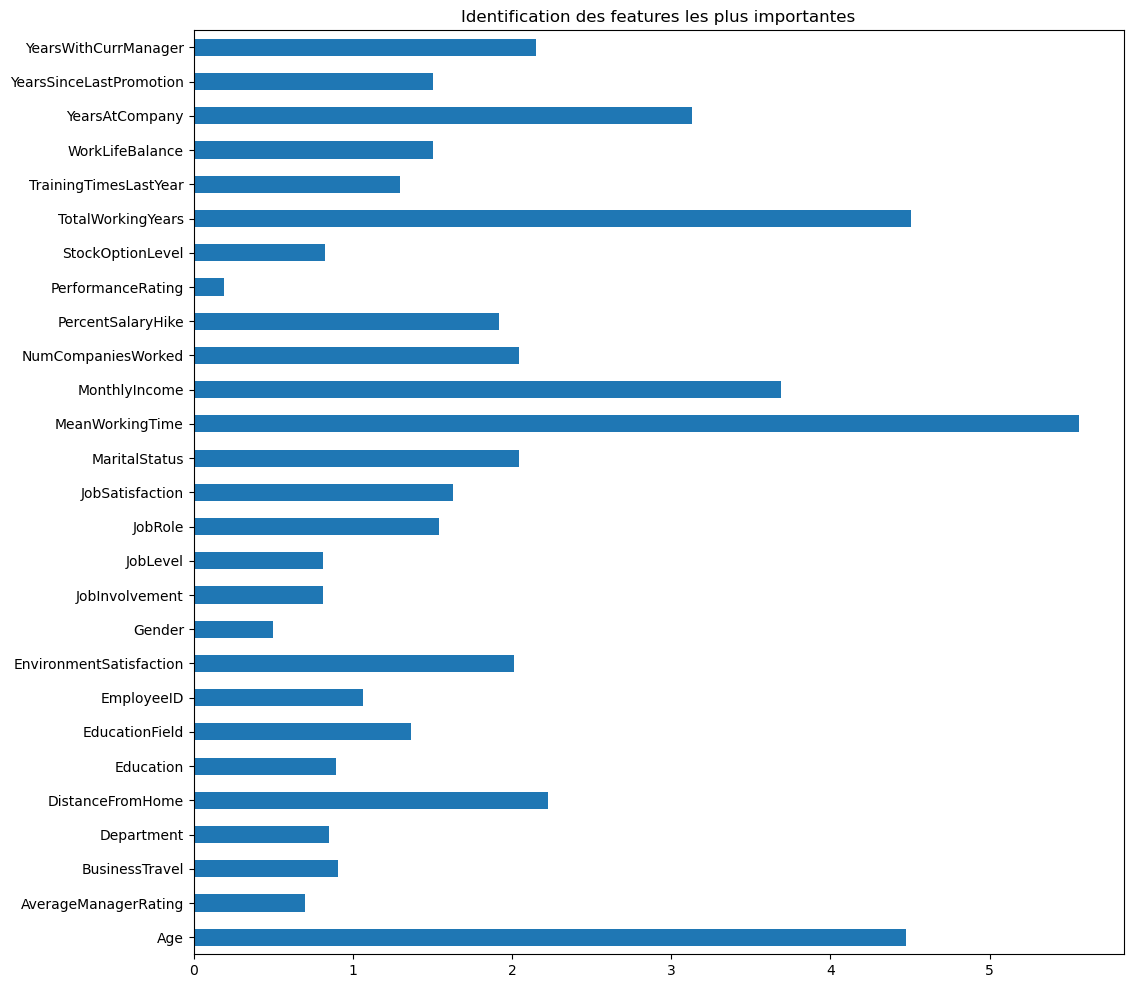

In [49]:
rfc = final_model_rfc
feature_dict = dict(sorted(zip(num_attribs_test + cat_attribs_test, list(rfc.feature_importances_ * 100))))

feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.barh(figsize=(12,12), title="Identification des features les plus importantes", legend=False);

## Profil Type

Voici le profil type d'un employé susceptible de partir durant l'année 2015 :

In [50]:
print("Age : " + str(round(final_dataset["Age"].where(final_dataset["Attrition"] == "Yes").mean())) + " ans")
print("Années de travail : " + str(round(final_dataset["TotalWorkingYears"].where(final_dataset["Attrition"] == "Yes").mean())) + " ans")
print("Temps moyen journalier au bureau : " + str(round(final_dataset["MeanWorkingTime"].where(final_dataset["Attrition"] == "Yes").mean())) + " heures")
print("Salaire : " + str(round(final_dataset["MonthlyIncome"].where(final_dataset["Attrition"] == "Yes").mean())) + " ₹")

Age : 34 ans
Années de travail : 8 ans
Temps moyen journalier au bureau : 8 heures
Salaire : 61683 ₹


## Solution pour l'entreprise

Nous avons répondu à la problématique donnée par HumanForYou, et pour améliorer le taux de turn-over, la direction peut appliquer plusieurs solutions :
- Rajouter des questions dans l'enquête employé
- Prédire le profil type pour l'année 2021 et le comparer avec celui de 2015
- Organiser des séminaires & activités pour ses employés
- Revaloriser les salaires

## Étique

La notion d'étique est essentiel lorsque l'on manipule des données personnelles et il ne faut pas discriminer une catégorie de personnes, en aucun cas.  
Dans ce projet, le but était de permettre aux employés de rester dans l'entreprise, et ne pas perdre en performance. Dans le cas contraire, nous aurions supprimé toutes les données personnelles des employés et la prédiction se serait basé sur leurs performances.

Fin du notebook.